# Time Series Forecasting with ARIMA

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

### Data

In [5]:
data = pd.read_csv('C:/projects/arima-forecasting-master/carcount.csv', index_col=0) 
data.head()

,day.of.week,car.count,weather,cloud.indicator
date,,,,
2010-01-01,Friday,101,0.1,clear
2010-01-02,Saturday,34,0.2,cloudy
2010-01-03,Sunday,113,0.4,clear
2010-01-04,Monday,5,0.6,cloudy
2010-01-05,Tuesday,124,0.1,clear


In [6]:
# any missing values?
data.isnull().values.any()

False

### Exploratory Data Analysis

<AxesSubplot:xlabel='date'>

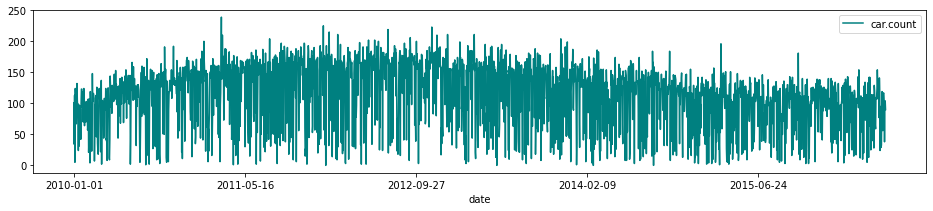

In [8]:
data.plot(y='car.count', color='teal', figsize=(16,3))  

### Cloud Indicator Variable

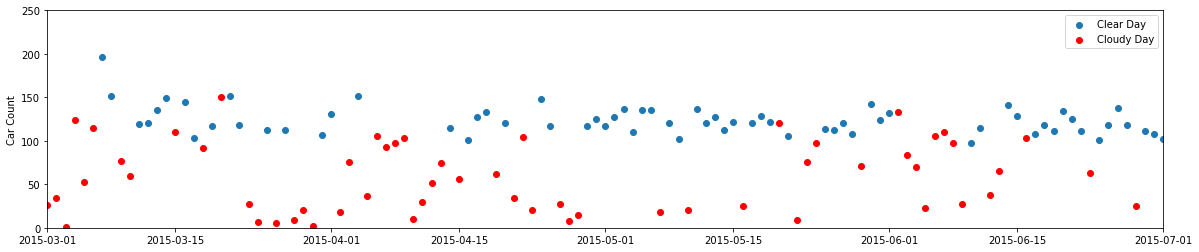

In [10]:
# let's take a closer look: summer 2015
start = datetime.datetime(2015,3,1)
end = datetime.datetime(2015,7,1)

cloudy_data = data.loc[(data['cloud.indicator'] == 'cloudy')]
clear_data = data.loc[(data['cloud.indicator'] == 'clear')]

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylim(0, 250)
ax.set_ylabel('Car Count')
plt.scatter(clear_data.index, clear_data['car.count'])  
plt.scatter(cloudy_data.index, cloudy_data['car.count'], color='r');     
ax.legend(['Clear Day', 'Cloudy Day'])


### Weather Variable

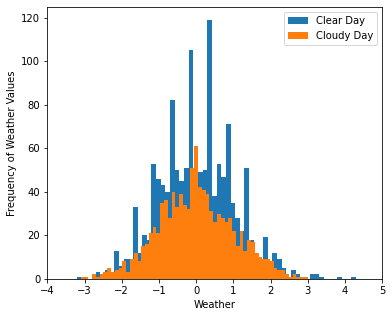

In [12]:
# frequency of Weather Indicator
plt.figure(figsize=(6,5))
ax = plt.gca()
ax.set_xlim(-4, 5)
plt.hist(clear_data['weather'], bins=60)
plt.hist(cloudy_data['weather'], bins=60)
ax.set_ylabel('Frequency of Weather Values')
ax.set_xlabel('Weather')
ax.legend(['Clear Day', 'Cloudy Day']);

Weather indicator doesn't appear to be well correlated with car count. 

Some ideas:
* Clear days are more likely to have a lower absolute value for weather. 
* Weather could be normalized temperature (easily verified by plotting over a year) 

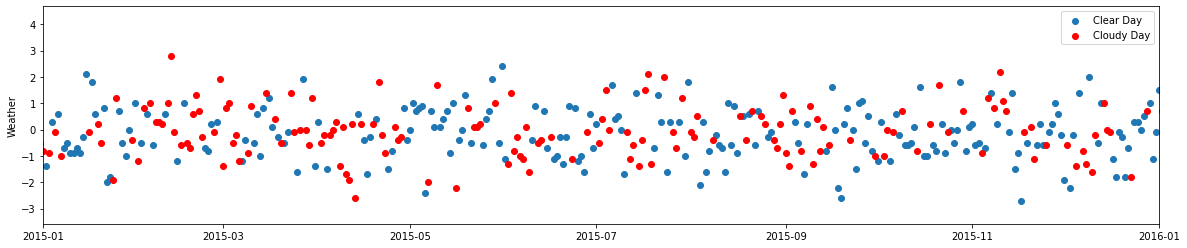

In [13]:
# seasonal trends for weather
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2016,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylabel('Weather')
plt.scatter(clear_data.index, clear_data['weather'])  
plt.scatter(cloudy_data.index, cloudy_data['weather'], color='r')     
ax.legend(['Clear Day', 'Cloudy Day']);



There is no obvious correlation between weather and temperature.




### Day of Week

Text(0, 0.5, 'Total Car Count')

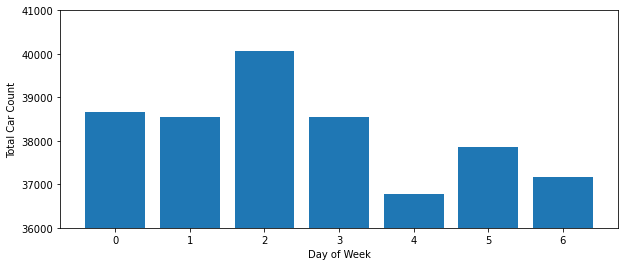

In [16]:
# TODO label properly x-axis
day = data['day.of.week'].unique()
plt.figure(figsize=(10,4))
ax = plt.gca()
plt.bar(np.arange(0,len(day)), data.groupby('day.of.week').sum()['car.count'])
ax.set_ylim(36000, 41000)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Car Count')

There is a day of week signal, could be an important feature to model on.

## Forecasting

# ARIMA

### Stationarity

In [18]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print (df_results)

In [19]:
test_stationarity(clear_data['car.count'])


Test Statistic            -1.544676
p-value                    0.511307
Lags                      20.000000
Observations            1332.000000
Critical Value (1%)       -3.435269
Critical Value (5%)       -2.863712
Critical Value (10%)      -2.567927
dtype: float64


Car count data is not stationary (test statistic is greater than critical value). Needs some transformations. 

In [20]:
# first difference
clear_data['diff'] = clear_data['car.count'] - clear_data['car.count'].shift(1)  
test_stationarity(clear_data['diff'].dropna(inplace=False))

#TODO: address warning 

Test Statistic         -1.090358e+01
p-value                 1.142956e-19
Lags                    2.400000e+01
Observations            1.327000e+03
Critical Value (1%)    -3.435287e+00
Critical Value (5%)    -2.863720e+00
Critical Value (10%)   -2.567931e+00
dtype: float64


<ipython-input-20-2381c5ce841c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_data['diff'] = clear_data['car.count'] - clear_data['car.count'].shift(1)


### ACF and PACF Graphs

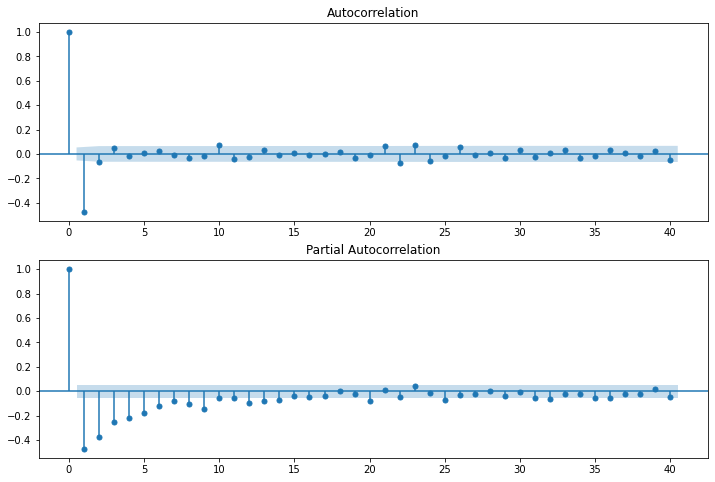

In [21]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff'][1:], lags=40, ax=ax2)

It looks like the ACF is lagged by 1 and that PACF is geometric.



In [22]:
clear_data['car.count.float'] = clear_data['car.count'].astype(float)
# convert int to float for ARIMA model input
# TODO: do this in a cleaner way

<ipython-input-22-acdf6b0ab913>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_data['car.count.float'] = clear_data['car.count'].astype(float)


In [24]:
print (type(clear_data['car.count.float'][5]))

<class 'numpy.float64'>


### Fitting Model

In [ ]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count.float'], order=(1,0,0)) 
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')

print (results.summary())

C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequen

                              ARMA Model Results                              
Dep. Variable:        car.count.float   No. Observations:                 1353
Model:                     ARMA(1, 0)   Log Likelihood               -5911.542
Method:                       css-mle   S.D. of innovations             19.107
Date:                Tue, 22 Dec 2020   AIC                          11829.084
Time:                        02:34:55   BIC                          11844.714
Sample:                             0   HQIC                         11834.936
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   143.6822      1.620     88.696      0.000     140.507     146.857
ar.L1.car.count.float     0.6798      0.020     34.036      0.000       0.641       0.719
        

C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Prince\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequen

                              ARMA Model Results                              
Dep. Variable:        car.count.float   No. Observations:                 1353
Model:                     ARMA(1, 1)   Log Likelihood               -5602.656
Method:                       css-mle   S.D. of innovations             15.193
Date:                Tue, 22 Dec 2020   AIC                          11213.312
Time:                        02:32:46   BIC                          11234.152
Sample:                             0   HQIC                         11221.115
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   122.0290     20.655      5.908      0.000      81.546     162.512
ar.L1.car.count.float     0.9992      0.001   1309.339      0.000       0.998       1.001
ma.L1.ca

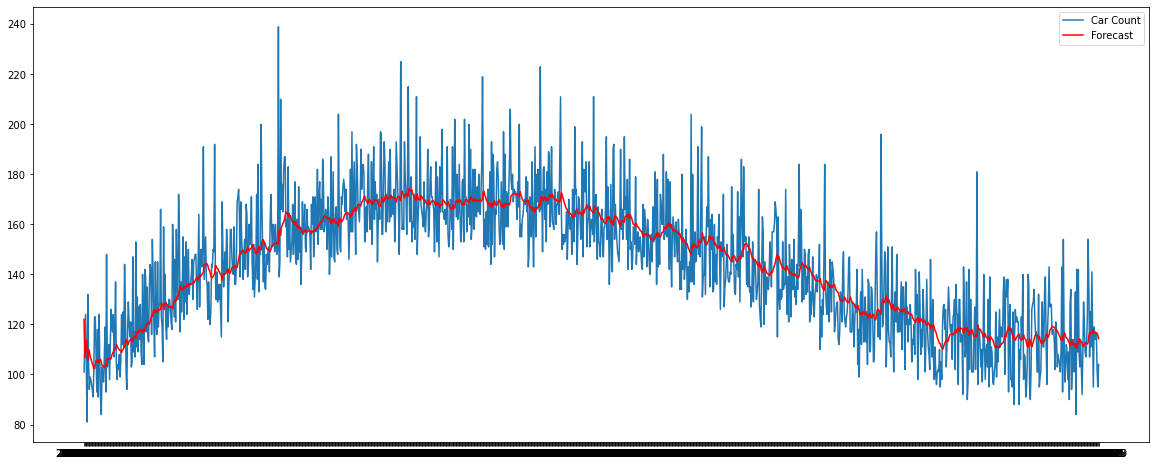

In [28]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count.float'], order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print (results.summary())

### Forecasting Model

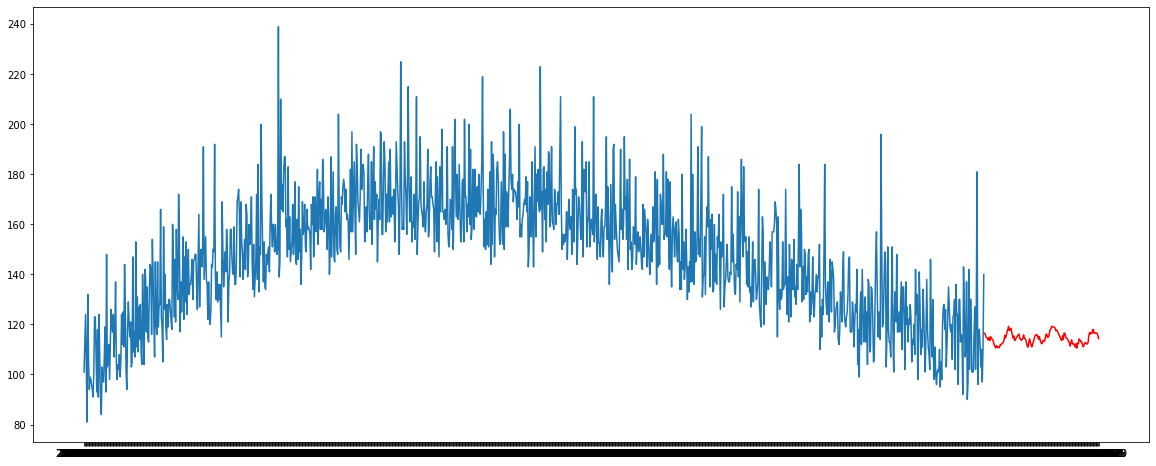

In [29]:
# forecast quick and dirty
# TODO: clean this up
fig = plt.figure(figsize=(20,8))
num_points = len(clear_data['car.count'])
x = results.predict(start=(1200), end=(1352), dynamic=False)

plt.plot(clear_data['car.count'][:1200])
plt.plot(x, color='r')